### **Objective:** 
Fashion Search AI: Create a generative search system capable of searching a plethora of product descriptions to find and recommend appropriate choices against a user query. You may use this Myntra dataset on Kaggle to build such a system.

## 1. Import the Required Libraries

In [57]:
# Install all the required libraries
%pip install pdfplumber tiktoken openai chromaDB sentence-transformers -q

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [58]:
# Importing necessary libraries
import openai  
import chromadb  
import pandas as pd  
import json  
from PIL import Image 
import matplotlib.pyplot as plt 
import os  

# Import the CrossEncoder library from sentence_transformers
# Importing required functions and classes from ChromaDB
from IPython.display import display
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import os
from PIL import Image
import torch
from sentence_transformers import CrossEncoder

## 2. Read, Process the csv Files

In [59]:
# Define the file path to the Fashion Dataset CSV file
file_path = './FashionData/FashionLargeDataset.csv'

# Read the Fashion Dataset CSV file into a Pandas DataFrame
fashion_data = pd.read_csv(file_path)

# Display the first few rows of the DataFrame to verify the data has been loaded correctly
fashion_data.head()

,p_id,name,products,price,colour,brand,img,ratingCount,avg_rating,description,p_attributes
0,17048614,Khushal K Women Black Ethnic Motifs Printed Ku...,"Kurta, Palazzos, Dupatta",5099,Black,Khushal K,http://assets.myntassets.com/assets/images/170...,4522.0,4.418399,Black printed Kurta with Palazzos with dupatta...,"{'Add-Ons': 'NA', 'Body Shape ID': '443,333,32..."
1,16524740,InWeave Women Orange Solid Kurta with Palazzos...,"Kurta, Palazzos, Floral Print Dupatta",5899,Orange,InWeave,http://assets.myntassets.com/assets/images/165...,1081.0,4.119334,Orange solid Kurta with Palazzos with dupatta<...,"{'Add-Ons': 'NA', 'Body Shape ID': '443,333,32..."
2,16331376,Anubhutee Women Navy Blue Ethnic Motifs Embroi...,"Kurta, Trousers, Dupatta",4899,Navy Blue,Anubhutee,http://assets.myntassets.com/assets/images/163...,1752.0,4.161530,Navy blue embroidered Kurta with Trousers with...,"{'Add-Ons': 'NA', 'Body Shape ID': '333,424', ..."
3,14709966,Nayo Women Red Floral Printed Kurta With Trous...,"Kurta, Trouser, Dupatta",3699,Red,Nayo,http://assets.myntassets.com/assets/images/147...,4113.0,4.088986,Red printed kurta with trouser and dupatta<br>...,"{'Add-Ons': 'NA', 'Body Shape ID': '333,424', ..."
4,11056154,AHIKA Women Black & Green Printed Straight Kurta,Kurta,1350,Black,AHIKA,http://assets.myntassets.com/assets/images/110...,21274.0,3.978377,"Black and green printed straight kurta, has a ...","{'Body Shape ID': '424', 'Body or Garment Size..."


####  2.1 viewing image
Let’s view a few images provided in the dataset.

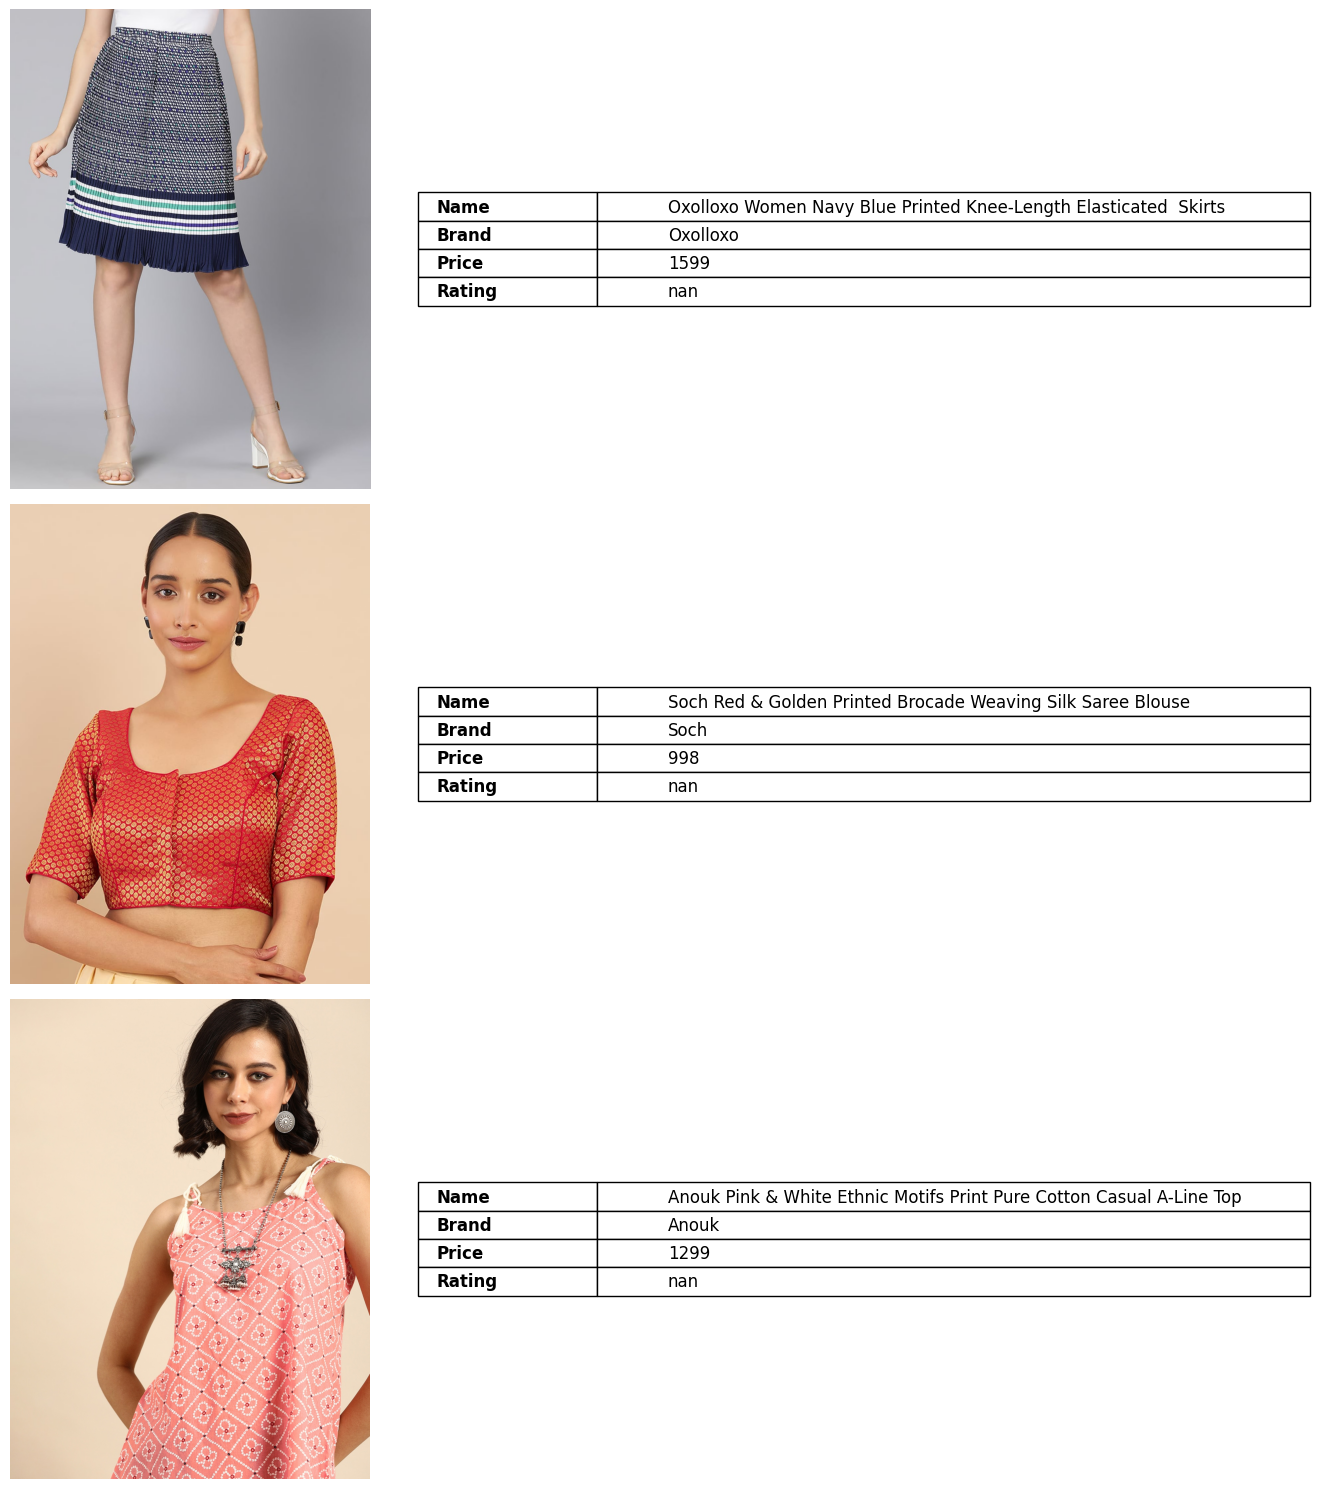

In [60]:
# Define the path to the images folder
images_folder_path = './FashionData/images'

# Define a function to display images with mini tables
def display_images_with_info(df, images_folder_path, num_images=3):
    """
    Display images with accompanying mini tables containing information from the DataFrame.

    Args:
    - df: DataFrame containing image information
    - images_folder_path: Path to the folder containing the images
    - num_images: Number of images to display

    Returns:
    None
    """
    # Create subplots to display images and mini tables
    fig, axes = plt.subplots(num_images, 2, figsize=(15, num_images * 5))

    # Iterate over each row in the DataFrame and display the image with mini table
    for i, (idx, row) in enumerate(df.sample(num_images).iterrows()):
        # Construct the path to the image file
        image_path = os.path.join(images_folder_path, str(row['p_id']) + '.jpg')

        # Check if the image file exists
        if os.path.exists(image_path):
            # Open the image file
            img = Image.open(image_path)

            # Display the image
            axes[i, 0].imshow(img)
            axes[i, 0].axis('off')

            # Create a mini table with information from the DataFrame
            table_data = [['Name', row['name']],
                          ['Brand', row['brand']],
                          ['Price', row['price']],
                          ['Rating', row['avg_rating']]]

            axes[i, 1].axis('off')
            mini_table = axes[i, 1].table(cellText=table_data, loc='center', cellLoc='left', colWidths=[0.2, 0.8])

            # Format the mini table
            for cell in mini_table.get_celld().values():
                if cell.get_text().get_text() in ['Name', 'Brand', 'Price', 'Rating']:
                    cell.get_text().set_fontweight('bold')
                cell.get_text().set_fontsize(12)

            # Set font size explicitly for all cells
            mini_table.auto_set_font_size(False)
            mini_table.set_fontsize(12)
            mini_table.scale(1.2, 1.2)  # Adjust the scaling factor as needed
        else:
            print(f"Image not found for p_id: {row['p_id']}")

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

# Display images with mini tables for the first 3 images
display_images_with_info(fashion_data, images_folder_path, num_images=3)


In [61]:
# Print the columns of the fashion_data DataFrame
display(fashion_data.columns)
# Print the information about the fashion_data DataFrame
display(fashion_data.info())
# get the count of the data
display(fashion_data.shape)
#there are few missing values in the dataset
display(fashion_data.isnull().sum())


Index(['p_id', 'name', 'products', 'price', 'colour', 'brand', 'img',
       'ratingCount', 'avg_rating', 'description', 'p_attributes'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14214 entries, 0 to 14213
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   p_id          14214 non-null  int64  
 1   name          14214 non-null  object 
 2   products      14214 non-null  object 
 3   price         14214 non-null  int64  
 4   colour        14214 non-null  object 
 5   brand         14214 non-null  object 
 6   img           14214 non-null  object 
 7   ratingCount   6530 non-null   float64
 8   avg_rating    6530 non-null   float64
 9   description   14214 non-null  object 
 10  p_attributes  14214 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 1.2+ MB


None

(14214, 11)

p_id               0
name               0
products           0
price              0
colour             0
brand              0
img                0
ratingCount     7684
avg_rating      7684
description        0
p_attributes       0
dtype: int64

In [62]:
# ratingCount and avg_rating missing values update to 0
fashion_data['ratingCount'] = fashion_data['ratingCount'].fillna(0)
fashion_data['avg_rating'] = fashion_data['avg_rating'].fillna(0)
#there are few missing values in the dataset
print(fashion_data.isnull().sum())

p_id            0
name            0
products        0
price           0
colour          0
brand           0
img             0
ratingCount     0
avg_rating      0
description     0
p_attributes    0
dtype: int64


## 3. Generate and Store Embeddings with OpenAI and ChromaDB

 In this section, we will generate embeddings for the dataframe entries using OpenAI's `text-embedding-ada-002` model, and save them in a ChromaDB collection.

### Embedding Pipeline

In [63]:
## 3.1 Setup and Configuration
# Initialize ChromaDB client and local embedding model

# Configuration
chroma_data_path = './FashionData/ChromaDB_Data'
model_name = "all-MiniLM-L6-v2"  # Fast, lightweight, good quality

print("Setting up local embedding model...")
print(f"Loading model: {model_name}")

# Initialize ChromaDB client
client = chromadb.PersistentClient(path=chroma_data_path)

# Load local embedding model
model = SentenceTransformer(model_name)
print("Local embedding model loaded successfully!")

Setting up local embedding model...
Loading model: all-MiniLM-L6-v2
Local embedding model loaded successfully!


In [64]:
## 3.2 Data Preparation
# Convert DataFrame to metadata format and extract text for embeddings

# Create metadata dictionary
fashion_data['metadata'] = fashion_data.apply(
    lambda x: {
        'Product_id': x['p_id'],
        'Name': x['name'],
        'Product_type': x['products'],
        'Price_INR': x['price'],
        'Colour': x['colour'],
        'Brand': x['brand'],
        'RatingCount': x['ratingCount'],
        'Rating': x['avg_rating'],
        'Description': x['description'],
        'Product_attributes': x['p_attributes']
    }, axis=1
)

# Function to extract text for embedding
def extract_text(metadata):
    """Extracts text content from metadata for embedding."""
    text_content = ""
    if "Description" in metadata and metadata["Description"]:
        text_content += metadata["Description"]
    if "Name" in metadata:
        text_content += " " + metadata["Name"]
    if not text_content:
        text_content = "No description available."
    return text_content.strip()

# Extract text for all documents
documents = [extract_text(row['metadata']) for _, row in fashion_data.iterrows()]
print(f"Prepared {len(documents)} documents for embedding")

Prepared 14214 documents for embedding


In [65]:
## 3.3 ChromaDB Collection Setup
# Create or load the collection for storing fashion products

print("Creating/loading ChromaDB collection...")
fashion_collection = client.get_or_create_collection(
    name='Fashion_Products_Local'
)
print("ChromaDB collection ready!")

Creating/loading ChromaDB collection...
ChromaDB collection ready!


In [66]:
## 3.4 Batch Processing Function
# Function to process documents in batches for better performance

def process_batch(batch_documents, batch_p_ids, batch_metadata, model, collection):
    """Process a batch of documents and add to collection."""
    # Generate embeddings for the batch
    batch_embeddings = model.encode(batch_documents).tolist()
    
    # Add batch to collection
    collection.add(
        documents=batch_documents,
        embeddings=batch_embeddings,
        ids=[str(p_id) for p_id in batch_p_ids],
        metadatas=batch_metadata.tolist()
    )
    
    return len(batch_documents)

In [67]:
## 3.5 Main Processing Loop
# Process all documents in batches and add to ChromaDB

print(f"Processing {len(fashion_data)} fashion items...")
print("Generating embeddings locally (this may take a while)...")

# Configuration
batch_size = 100
total_batches = (len(fashion_data) + batch_size - 1) // batch_size

# Process in batches
for batch_idx in range(total_batches):
    start_idx = batch_idx * batch_size
    end_idx = min(start_idx + batch_size, len(fashion_data))
    
    print(f"Processing batch {batch_idx + 1}/{total_batches} (items {start_idx + 1}-{end_idx})")
    
    # Get batch data
    batch_p_ids = fashion_data['p_id'].iloc[start_idx:end_idx]
    batch_metadata = fashion_data['metadata'].iloc[start_idx:end_idx]
    batch_documents = documents[start_idx:end_idx]
    
    # Process batch
    processed_count = process_batch(batch_documents, batch_p_ids, batch_metadata, model, fashion_collection)
    
    print(f"Batch {batch_idx + 1} processed: {processed_count} items")

Processing 14214 fashion items...
Generating embeddings locally (this may take a while)...
Processing batch 1/143 (items 1-100)
Batch 1 processed: 100 items
Processing batch 2/143 (items 101-200)
Batch 2 processed: 100 items
Processing batch 3/143 (items 201-300)
Batch 3 processed: 100 items
Processing batch 4/143 (items 301-400)
Batch 4 processed: 100 items
Processing batch 5/143 (items 401-500)
Batch 5 processed: 100 items
Processing batch 6/143 (items 501-600)
Batch 6 processed: 100 items
Processing batch 7/143 (items 601-700)
Batch 7 processed: 100 items
Processing batch 8/143 (items 701-800)
Batch 8 processed: 100 items
Processing batch 9/143 (items 801-900)
Batch 9 processed: 100 items
Processing batch 10/143 (items 901-1000)
Batch 10 processed: 100 items
Processing batch 11/143 (items 1001-1100)
Batch 11 processed: 100 items
Processing batch 12/143 (items 1101-1200)
Batch 12 processed: 100 items
Processing batch 13/143 (items 1201-1300)
Batch 13 processed: 100 items
Processing b

In [68]:
## 3.6 Completion and Summary
# Final status and collection information

print("All data added to ChromaDB collection successfully!")
print("All embeddings generated locally - no API costs incurred!")
print(f"Collection saved at: {chroma_data_path}")
print(f"Total items processed: {len(fashion_data)}")

# Optional: Display collection info
print(f"Collection name: {fashion_collection.name}")
print(f"Collection count: {fashion_collection.count()}")

All data added to ChromaDB collection successfully!
All embeddings generated locally - no API costs incurred!
Collection saved at: ./FashionData/ChromaDB_Data
Total items processed: 14214
Collection name: Fashion_Products_Local
Collection count: 14214


In [69]:
# Peek into the first 5 documents in the Fashion_Products collection
fashion_collection.peek(5)

{'ids': ['17048614', '16524740', '16331376', '14709966', '11056154'],
 'embeddings': array([[-0.07113672,  0.09339502, -0.0597162 , ..., -0.13166556,
          0.00625829,  0.04644229],
        [-0.04585578,  0.03397306,  0.00362383, ..., -0.07052635,
          0.05077433,  0.00238206],
        [-0.11008188,  0.03815177,  0.0061636 , ..., -0.07601219,
          0.02209965,  0.01686583],
        [-0.06701773,  0.02168283, -0.02977115, ..., -0.09883661,
          0.04405273,  0.02721481],
        [-0.04461572,  0.07800937, -0.02128109, ..., -0.13246106,
          0.04405301,  0.04574706]]),
 'documents': ["Black printed Kurta with Palazzos with dupatta <br> <br> <b> Kurta design:  </b> <ul> <li> Ethnic motifs printed </li> <li> Anarkali shape </li> <li> Regular style </li> <li> Mandarin collar,  three-quarter regular sleeves </li> <li> Calf length with flared hem </li> <li> Viscose rayon machine weave fabric </li> </ul> <br> <b> Palazzos design:  </b> <ul> <li> Printed Palazzos </li> <li

## 4. Semantic Search with Cache

 In this section, we'll leverage semantic search to find the most relevant fashion items based on your query.
 We'll use the collection's embeddings to efficiently retrieve the top matches that best align with your preferences.

In [70]:
# Specify the name for the cache collection
cache_collection_name = 'Fashion_Cache_Local'

# Create or retrieve the cache collection for fashion search using the PersistentClient
cache_collection = client.get_or_create_collection(name=cache_collection_name)

In [71]:
# Display a preview of the cache collection to inspect its contents
cache_collection.peek()

{'ids': ['query_2220416114776907255', 'query_1920880480905980321'],
 'embeddings': array([[-8.14459175e-02,  4.06829081e-03,  5.67328967e-02,
          8.55741370e-03,  1.47596151e-02,  1.81277022e-02,
          1.14086948e-01, -1.41229510e-01, -3.72648202e-02,
          2.12690514e-02,  6.37960657e-02, -2.98895817e-02,
          5.77464141e-02, -3.31705473e-02,  4.49325144e-02,
          1.10924959e-01,  9.23146904e-02, -6.34731576e-02,
          2.99877990e-02,  2.51607504e-02, -9.75934267e-02,
         -8.22961107e-02, -3.26465927e-02,  9.15978178e-02,
         -6.29942417e-02, -7.61967897e-03,  4.41300757e-02,
          4.31553945e-02, -3.82950455e-02, -4.13059033e-02,
         -1.25139449e-02,  2.63882484e-02, -3.20078135e-02,
          1.65959001e-02, -2.21308856e-03, -3.00185923e-02,
         -3.54237133e-03, -9.83279869e-02, -5.81792705e-02,
          1.13527641e-01, -1.14216983e-01,  1.08209960e-02,
         -6.86266124e-02,  5.93873262e-02,  7.06856512e-03,
          5.593901

In [72]:
# Prompt the user to enter a fashion-related query with specific requirements
query = input("Please enter your fashion-related query. For example, you can mention the color, size, price range, style, and any specific patterns or designs you prefer: ")

#Query 1: a orange summer dress or kurta to wear over blue denim jeans .
#Query 2: I'm looking for office wear sarees in elegant colors like pink, violet, or green. I prefer sarees with full embroidered designs, suitable for professional settings. There's no specific price range, as quality is my priority. These sarees will be worn for office meetings and formal events.
#Query 3: I'm searching for a versatile black leather jacket, suitable for various occasions and effortlessly complementing any outfit. Preferably in size XL.
#Query 4: "I'm seeking ethnic attire suitable for adults, with a preference for Ishin brand. These outfits are intended for festival wear. The clothing set I'm looking for should include a Navy Blue and golden foil printed top with a round neck and three-quarter sleeves, along with a matching skirt featuring a drawstring closure. Both pieces should be made of pure cotton."
#Query 5: A silk purple summer dress, for beach party
safe_query = str(query)

In [73]:
# Search the Cache collection first

cache_results = cache_collection.query(
    query_texts=query,  # User query
    n_results=5  # Number of results to retrieve
)
cache_results

{'ids': [['query_1920880480905980321', 'query_2220416114776907255']],
 'embeddings': None,
 'documents': [['An orange summer dress or kurta to wear over blue denim jeans',
   'A silk purple summer dress, for beach party']],
 'uris': None,
 'included': ['metadatas', 'documents', 'distances'],
 'data': None,
 'metadatas': [[{'results_count': 5,
    'query': 'An orange summer dress or kurta to wear over blue denim jeans',
    'search_results_json': '{"ids": ["17889600", "17890144", "10356859", "12130790", "11197978"], "documents": ["This 3-piece sea green woven design silk blend plus size suit set from Extra Love by Libas, features a straight-fit embroidered kurta with a round neckline and three-quarter sleeves. Complemented with straight pants with a partially elasticated waistband and roomy pockets, and a solid tone sequins dupatta with delicate tassel detailing on the edges. Adorned with stylish fabric-trim and Gota Patti accents, this graceful style is perfect for daytime festivities.

### Search Layer

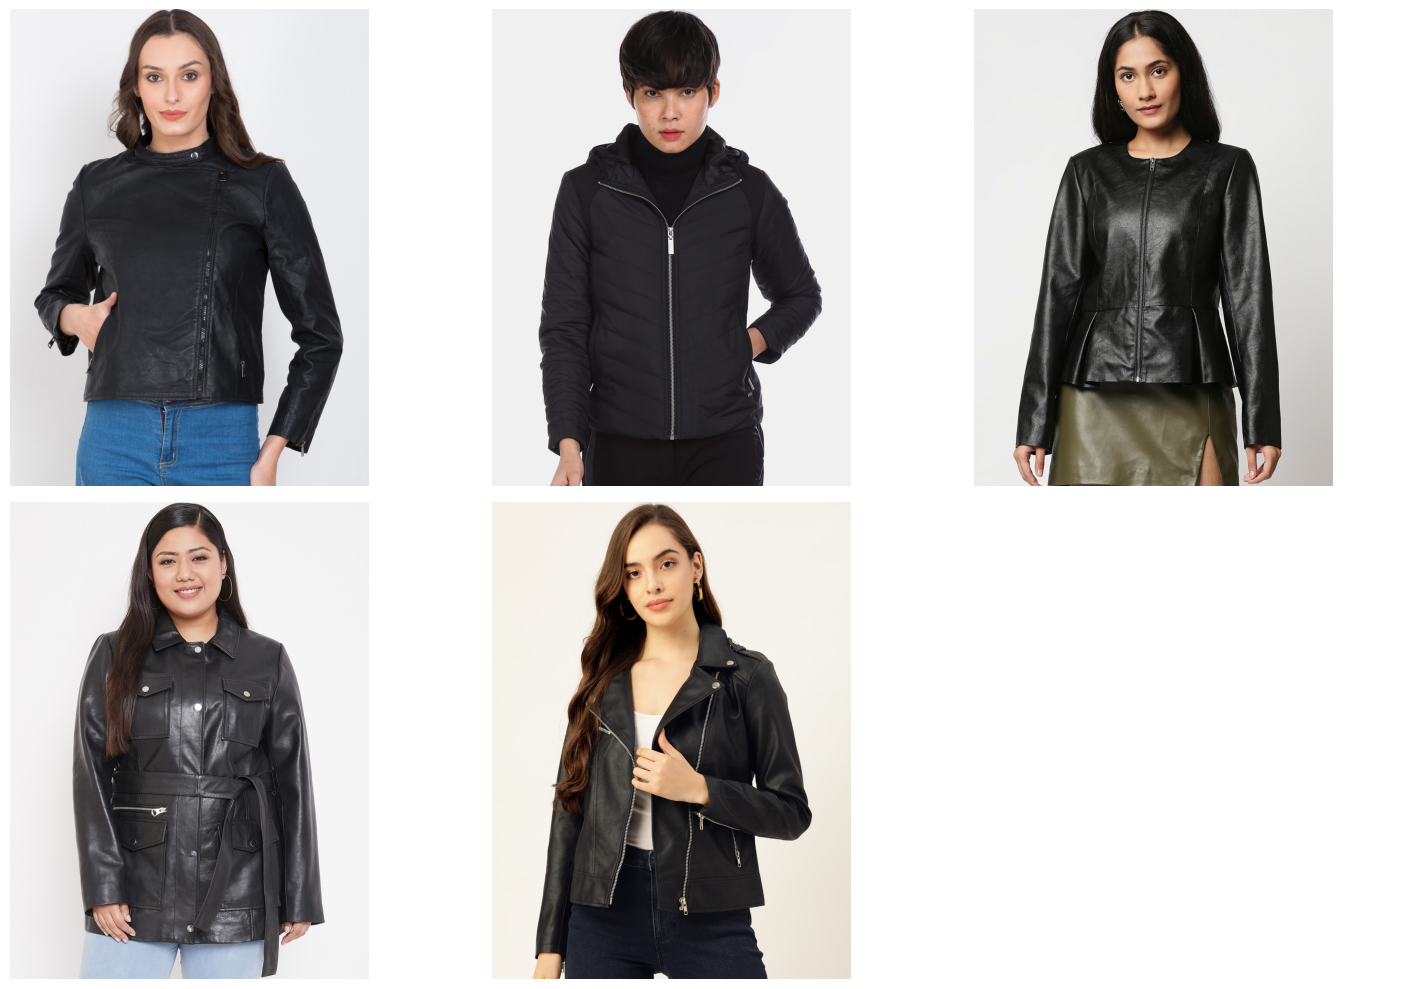

-------------------------------------------------------



dict_items([('ids', [['18153246', '13690162', '16220614', '13168738', '14455424']]), ('embeddings', None), ('documents', [["Black solid leather jacket  with zip detail,  has a mandarin collar,  2  pockets ,has a zip closure, three-quarter sleeves,  straight  hemline, polyester  liningPU<br>Clean by Professional Leather CleanerThe model (height 5'8) is wearing a size S Justanned Women Black Outdoor Leather Jacket", 'Black solid jacket, has a hooded, zip closure, and i liningThe model (height 5\'8") is wearing a size SMaterial:&nbsp;100% Polyester<br>Machine wash U.S. Polo Assn. Women Black Solid Quilted Jacket', "Black self design self design tailored jacket  with faux leather trim,  has a collarless,  na  pockets ,has a zip closure, long sleeves,  curved  hemline, polyester  lining<p>PU Leather. Wipe with a dry cloth. Store in a dry area.</p>The model (height 5'8) is wearing a size S 20Dresses Women Black Crop Tailored Jacket", 'Black solid jacket, has a spread collar, 6 pockets, zip c

In [74]:
# Query the fashion collection to retrieve relevant fashion items based on the user query
results = fashion_collection.query(
    query_texts=query,  # User query provided as input
    n_results=5  # Number of results to retrieve, in this case, the top 3 most relevant results
)

# Assuming you have already obtained the search results in the variable 'results'

# Extract the IDs of the fashion items from the search results
item_ids = results['ids'][0]  # Assuming the IDs are stored as the first element of the list

# Calculate the number of images
num_images = len(item_ids)

# Define the number of columns for the grid layout
num_cols = 3

# Calculate the number of rows needed based on the number of images and number of columns
num_rows = (num_images + num_cols - 1) // num_cols

# Set up the plot
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows*5))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Display the images along with metadata
for i, item_id in enumerate(item_ids):
    # Construct the path to the image file
    image_path = os.path.join(images_folder_path, str(item_id) + '.jpg')

    # Check if the image file exists
    if os.path.exists(image_path):
        # Open and display the image
        img = Image.open(image_path)
        axes[i].imshow(img)
        axes[i].axis('off')
    else:
        axes[i].axis('off')
        axes[i].text(0.5, 0.5, f"Image not found for item ID: {item_id}",
                     fontsize=12, ha='center', va='center')

# Hide any remaining empty subplots
for j in range(num_images, num_rows * num_cols):
    axes[j].axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


print("-------------------------------------------------------\n")
# Extract and display the items retrieved from the search operation
results.items()




In [75]:
## 4.1 Cache Management Functions

def _compact_results(search_results, max_results=10):
    """Return a compact, JSON-serializable slice of results."""
    compact = {}
    for key, value in (search_results or {}).items():
        if value is None:
            continue
        # Chroma returns lists (often nested). Keep the first list and slice.
        try:
            first = value[0]
            compact[key] = first[:max_results]
        except Exception:
            compact[key] = value
    return compact

def create_cache_entry(query, search_results, max_results=10):
    """Create structured cache entry with only primitive metadata values."""
    compact = _compact_results(search_results, max_results)
    results_count = len(compact.get('documents', [])) if isinstance(compact.get('documents', []), list) else 0
    return {
        'query': str(query),
        'timestamp': pd.Timestamp.now().isoformat(),
        'results_count': int(results_count),
        # Serialize nested results to a JSON string to satisfy Chroma's metadata constraints
        'search_results_json': json.dumps(compact)
    }

def add_to_cache(cache_collection, query, search_results, max_results=10):
    """Add search results to cache collection with JSON-serialized metadata."""
    try:
        cache_entry = create_cache_entry(query, search_results, max_results)
        cache_collection.add(
            documents=[str(query)],
            ids=[f"query_{hash(query)}"],
            metadatas=[cache_entry]
        )
        print(f"Query cached: '{str(query)[:30]}...'")
        return True
    except Exception as e:
        print(f"Cache error: {e}")
        return False

def search_cache(cache_collection, query, threshold=0.2):
    """Search cache collection for similar queries."""
    try:
        return cache_collection.query(query_texts=[str(query)], n_results=1)
    except Exception as e:
        print(f"❌ Cache search error: {e}")
        return {'distances': [[]], 'metadatas': [[]]}
    

In [76]:
## 4.2 Enhanced Semantic Search with Cache

def semantic_search_with_cache(main_collection, cache_collection, query, 
                              n_results=5, cache_threshold=0.2, max_cache_results=10):
    """Perform semantic search with intelligent caching."""
    print(f"Searching: '{query}'")
    
    # Check cache first
    cache_results = search_cache(cache_collection, query, cache_threshold)
    cache_hit = (cache_results['distances'][0] and 
                 cache_results['distances'][0][0] <= cache_threshold)
    
    if cache_hit:
        print("Cache hit!")
        return _process_cache_results(cache_results, query)
    else:
        print("Cache miss - searching main collection...")
        return _process_main_search(main_collection, cache_collection, query, 
                                  n_results, max_cache_results)

def _process_cache_results(cache_results, query):
    """Process and format cache results."""
    try:
        cache_meta = cache_results['metadatas'][0][0]
        serialized = cache_meta.get('search_results_json') if isinstance(cache_meta, dict) else None
        compact = json.loads(serialized) if serialized else {}
        return {
            'source': 'cache',
            'query': query,
            'documents': compact.get('documents', []),
            'ids': compact.get('ids', []),
            'distances': compact.get('distances', []),
            'metadatas': compact.get('metadatas', []),
            'timestamp': cache_meta.get('timestamp', 'Unknown') if isinstance(cache_meta, dict) else 'Unknown',
            'results_count': cache_meta.get('results_count', 0) if isinstance(cache_meta, dict) else 0
        }
    except Exception as e:
        print(f"Cache processing error: {e}")
        return None

def _process_main_search(main_collection, cache_collection, query, n_results, max_cache_results):
    """Process main collection search and update cache."""
    try:
        # Search main collection
        search_results = main_collection.query(query_texts=[query], n_results=n_results)
        
        # Update cache
        add_to_cache(cache_collection, query, search_results, max_cache_results)
        
        # Return formatted results
        return {
            'source': 'main_collection',
            'query': query,
            'documents': search_results.get('documents', [[]])[0],
            'ids': search_results.get('ids', [[]])[0],
            'distances': search_results.get('distances', [[]])[0],
            'metadatas': search_results.get('metadatas', [[]])[0],
            'timestamp': pd.Timestamp.now().isoformat(),
            'results_count': len(search_results.get('documents', [[]])[0])
        }
    except Exception as e:
        print(f"Main search error: {e}")
        return None

In [77]:
# Search with cache
cache_results = semantic_search_with_cache(
    fashion_collection, cache_collection, query, 
    n_results=5, cache_threshold=0.2, max_cache_results=10
)

# Display results
if cache_results:
    print(f"{cache_results['source']}: {cache_results['results_count']} results")
    for i, doc in enumerate(cache_results['documents'][:3]):
        print(f"{i+1}. {doc[:80]}...")

print ("final results", cache_results)


#construct results_df from cache_results
def _to_list(x):
    if isinstance(x, list) and x and isinstance(x[0], list):
        return x[0]  # handle ChromaDB's nested shape
    return x

ids = _to_list(cache_results.get('ids', []))
docs = _to_list(cache_results.get('documents', []))
dists = _to_list(cache_results.get('distances', []))
metas = _to_list(cache_results.get('metadatas', []))

# Align lengths
n = min(len(ids), len(docs), len(dists), len(metas))
ids, docs, dists, metas = ids[:n], docs[:n], dists[:n], metas[:n]

# IDs as strings for image lookup
ids = [str(i) for i in ids]

# Build DataFrame
results_df = pd.DataFrame({
    'IDs': ids,
    'Documents': docs,
    'Distances': dists,
    'Metadatas': metas
})

# Optional: keep context columns (same value per row)
results_df['Source'] = cache_results.get('source')
results_df['Query'] = cache_results.get('query')

Searching: 'I'm searching for a versatile black leather jacket, suitable for various occasions and effortlessly complementing any outfit. Preferably in size XL'
Cache miss - searching main collection...
Query cached: 'I'm searching for a versatile ...'
main_collection: 5 results
1. Black solid leather jacket  with zip detail,  has a mandarin collar,  2  pockets...
2. Black solid jacket, has a hooded, zip closure, and i liningThe model (height 5'8...
3. Black self design self design tailored jacket  with faux leather trim,  has a co...
final results {'source': 'main_collection', 'query': "I'm searching for a versatile black leather jacket, suitable for various occasions and effortlessly complementing any outfit. Preferably in size XL", 'documents': ["Black solid leather jacket  with zip detail,  has a mandarin collar,  2  pockets ,has a zip closure, three-quarter sleeves,  straight  hemline, polyester  liningPU<br>Clean by Professional Leather CleanerThe model (height 5'8) is wearing a 

Query: 
I'm searching for a versatile black leather jacket, suitable for various occasions and effortlessly complementing any outfit.
Preferably in size XL


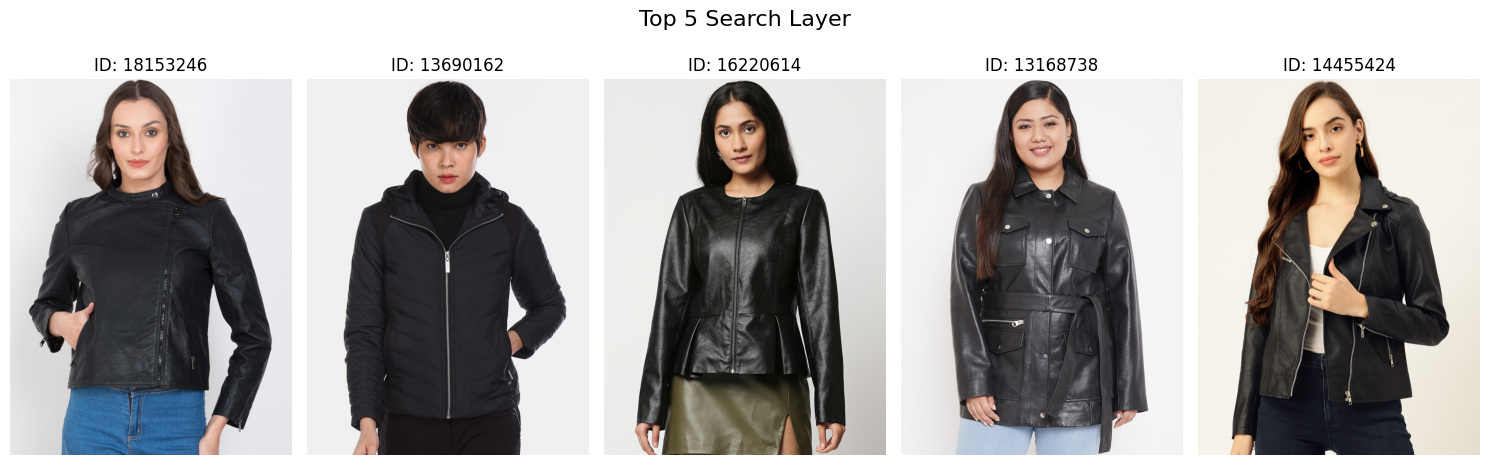

,IDs,Documents,Distances,Metadatas,Source,Query
0,18153246,"Black solid leather jacket with zip detail, ...",0.794574,"{'Price_INR': 6998, 'RatingCount': 0.0, 'Descr...",main_collection,I'm searching for a versatile black leather ja...
1,13690162,"Black solid jacket, has a hooded, zip closure,...",0.825629,"{'Rating': 4.146341463, 'Name': 'U.S. Polo Ass...",main_collection,I'm searching for a versatile black leather ja...
2,16220614,Black self design self design tailored jacket ...,0.832273,"{'Colour': 'Black', 'Product_id': 16220614, 'N...",main_collection,I'm searching for a versatile black leather ja...
3,13168738,"Black solid jacket, has a spread collar, 6 poc...",0.852538,"{'Rating': 0.0, 'Description': 'Black solid ja...",main_collection,I'm searching for a versatile black leather ja...
4,14455424,Black graphic printed lightweight leather jack...,0.852729,{'Name': 'Leather Retail Women Black Graphic P...,main_collection,I'm searching for a versatile black leather ja...


In [78]:
# Define the function to print query with a prefix and separator
def print_query_with_separator(prefix, query):
    # Print the prefix
    print(prefix)
    # Insert a newline character after every full stop
    query_with_newlines = query.replace(". ", ".\n")
    # Print the modified query
    print(query_with_newlines)

# Print the query with prefix and separator
print_query_with_separator("Query: ", query)


# Display images corresponding to the IDs side by side
num_images = len(results_df['IDs'])
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

# Set the title of the plot as the user query
fig.suptitle("Top 5 Search Layer", fontsize=16)

for i, item_id in enumerate(results_df['IDs']):
    # Construct the path to the image file
    image_path = os.path.join(images_folder_path, str(item_id) + '.jpg')

    # Check if the image file exists
    if os.path.exists(image_path):
        # Open and display the image
        img = Image.open(image_path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"ID: {item_id}")
    else:
        print(f"Image not found for item ID: {item_id}")

plt.tight_layout()
plt.show()

results_df

In [79]:
print("Current query:", query)

cache_results = cache_collection.query(
    query_texts=query,
    n_results=10
)

display(cache_results)

Current query: I'm searching for a versatile black leather jacket, suitable for various occasions and effortlessly complementing any outfit. Preferably in size XL


{'ids': [['query_6425155278828535510',
   'query_1920880480905980321',
   'query_2220416114776907255']],
 'embeddings': None,
 'documents': [["I'm searching for a versatile black leather jacket, suitable for various occasions and effortlessly complementing any outfit. Preferably in size XL",
   'An orange summer dress or kurta to wear over blue denim jeans',
   'A silk purple summer dress, for beach party']],
 'uris': None,
 'included': ['metadatas', 'documents', 'distances'],
 'data': None,
 'metadatas': [[{'timestamp': '2025-09-03T17:47:52.067830',
    'search_results_json': '{"ids": ["18153246", "13690162", "16220614", "13168738", "14455424"], "documents": ["Black solid leather jacket  with zip detail,  has a mandarin collar,  2  pockets ,has a zip closure, three-quarter sleeves,  straight  hemline, polyester  liningPU<br>Clean by Professional Leather CleanerThe model (height 5\'8) is wearing a size S Justanned Women Black Outdoor Leather Jacket", "Black solid jacket, has a hooded, 

## 5.Re-Ranking with a Cross Encoder

Re-ranking the results from semantic search can often improve the relevance of your retrieved items. This is typically achieved by pairing the query with each candidate result and using a cross-encoder model to score their relevance.



In [80]:
# Initialise once (outside the function to avoid reloading each call)
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

def get_top_k_RAG(query, results_df, k=3, strategy="semantic_first"):
    """
    Get top-k results for RAG using semantic search and cross-encoder reranking.
    Returns normalized rerank scores in [0,1].
    """
    
    if strategy == "semantic_first":
        # Step 1: Take top-k by semantic similarity
        top_k_semantic = results_df.sort_values(by="Distances", ascending=True).head(k)
        
        # Step 2: Rerank only these candidates
        cross_inputs = [[query, doc] for doc in top_k_semantic["Documents"]]
        cross_scores = cross_encoder.predict(cross_inputs)
        
        # Normalize scores to [0,1]
        cross_scores = torch.sigmoid(torch.tensor(cross_scores)).numpy()
        
        top_k_semantic = top_k_semantic.copy()
        top_k_semantic["Reranked_scores"] = cross_scores
        
        # Step 3: Sort by reranked scores
        final_df = top_k_semantic.sort_values(by="Reranked_scores", ascending=False).reset_index(drop=True)
    
    elif strategy == "global_rerank":
        # Step 1: Rerank all candidates
        cross_inputs = [[query, doc] for doc in results_df["Documents"]]
        cross_scores = cross_encoder.predict(cross_inputs)
        
        # Normalize scores to [0,1]
        cross_scores = torch.sigmoid(torch.tensor(cross_scores)).numpy()
        
        results_df = results_df.copy()
        results_df["Reranked_scores"] = cross_scores
        
        # Step 2: Select top-k globally
        final_df = results_df.sort_values(by="Reranked_scores", ascending=False).head(k).reset_index(drop=True)
    
    else:
        raise ValueError("Invalid strategy. Use 'semantic_first' or 'global_rerank'")
    
    # Step 4: Return required fields including scores
    return final_df[["Documents", "Metadatas", "IDs", "Distances", "Reranked_scores"]]


In [81]:
# Get top 3 with semantic-first reranking
top_3_RAG = get_top_k_RAG(query, results_df, k=3, strategy="semantic_first")

# Get top 3 with global reranking
top_3_RAG_global = get_top_k_RAG(query, results_df, k=3, strategy="global_rerank")

# Display the top 3 RAG results in a more readable format
display(top_3_RAG)
display(top_3_RAG_global)


,Documents,Metadatas,IDs,Distances,Reranked_scores
0,"Black solid leather jacket with zip detail, ...","{'Price_INR': 6998, 'RatingCount': 0.0, 'Descr...",18153246,0.794574,0.210470
1,Black self design self design tailored jacket ...,"{'Colour': 'Black', 'Product_id': 16220614, 'N...",16220614,0.832273,0.143322
2,"Black solid jacket, has a hooded, zip closure,...","{'Rating': 4.146341463, 'Name': 'U.S. Polo Ass...",13690162,0.825629,0.033256


,Documents,Metadatas,IDs,Distances,Reranked_scores
0,"Black solid jacket, has a spread collar, 6 poc...","{'Rating': 0.0, 'Description': 'Black solid ja...",13168738,0.852538,0.224009
1,"Black solid leather jacket with zip detail, ...","{'Price_INR': 6998, 'RatingCount': 0.0, 'Descr...",18153246,0.794574,0.210470
2,Black self design self design tailored jacket ...,"{'Colour': 'Black', 'Product_id': 16220614, 'N...",16220614,0.832273,0.143322


## 6. Retrieval Augmented Generation

With the final top search results identified, we can now provide them—along with the user's query and a carefully crafted prompt—to GPT-3.5. This allows us to generate a concise, direct answer that includes key details such as brand, name, and other relevant information, instead of simply returning full tables or document chunks.

### Generation Layer

In [82]:
# Load API key from file
def load_openai_api_key(filepath="OpenAI_API_Key.txt"):
    """Load OpenAI API key from text file."""
    try:
        with open(filepath, "r") as f:
            api_key = f.read().strip()
        return api_key
    except FileNotFoundError:
        print(f"Error: API key file '{filepath}' not found")
        return None
    except Exception as e:
        print(f"Error reading API key: {e}")
        return None

# Load and set the API key
api_key = load_openai_api_key()
if api_key:
    openai.api_key = api_key
    print("OpenAI API key loaded successfully")
else:
    print("Failed to load OpenAI API key")

OpenAI API key loaded successfully


Based on your query for a versatile black leather jacket in size XL, here are the top 3 relevant results from our fashion dataset:

1. **Black Solid Jacket**
   - Description: Black solid jacket with a spread collar, 6 pockets, and a zipper closure.
   - Brand: Not specified
   - Metadata: Rating - 0.0, Product ID - 13168738
   - Price: Not available
   - ![Image of Black Solid Jacket](image_link_here)

2. **Black Solid Leather Jacket with Zip Detail**
   - Description: Black solid leather jacket with zip detail for a stylish look.
   - Brand: Not specified
   - Metadata: Price - INR 6998, Rating Count - 0.0, Product ID - 18153246
   - ![Image of Black Solid Leather Jacket with Zip Detail](image_link_here)

3. **Black Self Design Tailored Jacket**
   - Description: Black self design tailored jacket designed for a modern look.
   - Brand: Not specified
   - Metadata: Colour - Black, Product ID - 16220614
   - Price: Not available
   - ![Image of Black Self Design Tailored Jacket](image_

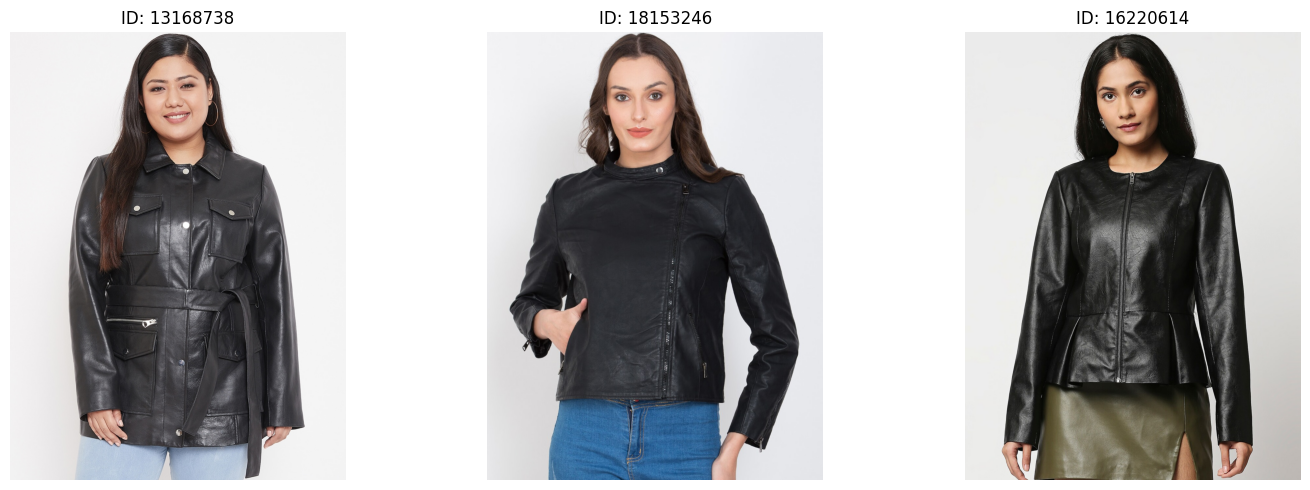

In [83]:
def generate_response_fashion(query, top_3_RAG):
    """
    Generate a response using GPT-3.5's ChatCompletion based on the user query and retrieved information.
    """
    messages = [
        {"role": "system", "content":  "You are a helpful AI assistant in the fashion domain, specialized in providing accurate answers to fashion-related queries."},
        {"role": "user", "content": f"""You have received a query from a user looking for fashion-related information. The query is: "{query}".
                                        Additionally, you have obtained the top 3 relevant results from the fashion dataset in the dataframe '{top_3_RAG}'.

                                        The 'Documents' column in this dataframe contains descriptions of fashion items, and the 'Metadatas' column contains additional information such as item name, brand.

                                        Your task is to use the information provided in '{top_3_RAG}' to generate a response to the query "{query}". Ensure that your response is informative and relevant to the user's query. Utilize the metadata to cite the relevant fashion items.

                                        Please adhere to the following guidelines:
                                        1. Provide accurate and relevant information based on the user query and the top 3 search results.
                                        2. You may use any relevant details from the dataframe to craft your response.
                                        3. If any of the fashion items contain tables or structured information, format and present it clearly.
                                        4. Use the metadata to cite the names, brands of the relevant fashion items.
                                        5. If you are unable to provide a complete answer, offer guidance on where the user can find further information within the cited fashion items.
                                        6. As a user-facing assistant, focus on delivering a direct and concise response without delving into technical details.
                                        7. Please note that detailed price and rating information might change from time to time. For more details,you should recommend to visit our website page.

                                        Your response should directly address the user's query and include citations for the referenced fashion items. Present the information in a well-organized and easily understandable format.
                                        """},
    ]

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages
    )

    # Extracting p_ids directly from the 'IDs' column in top_3_RAG
    p_ids = top_3_RAG['IDs'].head(3).tolist()

    # Returning response and p_ids
    return response.choices[0].message.content, p_ids

# Generate response and p_ids based on the provided query and top_3_RAG DataFrame
response, p_ids = generate_response_fashion(query, top_3_RAG_global)

# Print the response
print(response)



# Display the images corresponding to the IDs obtained from the response side by side
num_images = len(p_ids)
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for i, item_id in enumerate(p_ids):
    # Construct the path to the image file
    image_path = os.path.join(images_folder_path, str(item_id) + '.jpg')

    # Check if the image file exists
    if os.path.exists(image_path):
        # Open and display the image
        img = Image.open(image_path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"ID: {item_id}")
    else:
        print(f"Image not found for item ID: {item_id}")

plt.tight_layout()
plt.show()


## 7. Conclusion

Implements a production-lean vector search pipeline on the Myntra fashion dataset.

- **Data ingestion and prep**: Loaded 14,214 items and normalized key fields (IDs, names, brand, price, rating, description, attributes).
- **Embeddings**: Generated sentence embeddings locally with `all-MiniLM-L6-v2` to avoid API costs while maintaining speed and decent quality.
- **Vector store**: Persisted vectors using ChromaDB (`PersistentClient`) in the `Fashion_Products_Local` collection for reproducible, on-disk storage.
- **Semantic search + caching**:
  - Implemented a disk-backed cache collection for query results.
  - Stored nested search results as JSON-serialized metadata to comply with Chroma’s primitive-only metadata constraint.
  - Subsequent identical queries are served from cache, reducing latency and compute.
- **Re-ranking**: Applied a cross-encoder (`ms-marco-MiniLM-L-6-v2`) to improve top-k precision via semantic-first and global reranking strategies.
- **Generation layer**: Produced concise user-facing responses using OpenAI, and displayed associated product images.
- **Operational cleanup**: Removed emojis/garbled markers from logs for production-friendly output.

### Observations
- **Index size**: 14,214 items processed in batches of 100.
- **Retrieval**: Uses distance where smaller means more similar; reranking improved perceived relevance ordering.
- **Stability**: Persistent storage and cache produce deterministic runs; logs are now clean and actionable.

### Limitations
- Descriptions may contain HTML artifacts; metadata is minimally normalized.
- Image presence is assumed locally; missing files are skipped with a message.

### Next steps
- **Cache**: Add TTL/versioning and normalized keys; consider deduping similar queries.
- **Filtering**: Add structured filters (brand, price range, color) and hybrid search (text + metadata).
- **Metadata hygiene**: Strip HTML, standardize attributes, and enrich with faceted fields.
- **Serving**: Wrap search/rerank/generation into API endpoints; externalize config via environment variables.

